For jgraph, start this notebook with `--NotebookApp.iopub_data_rate_limit=10000000000`.

In [17]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
import IPython
from IPython.display import HTML, display

In [18]:
import jgraph
import local_config
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import re

`local_config.collect_data()` takes an optional `in_dir` parameter.
The default is `data` for a folder in the same directory as this 
notebook and `local_config.py` with that name containing one or
more \*.CSV files.

In [19]:
data = local_config.collect_data()

📊 data/DSM_Data.csv, 📁 data/Release 2 Data	📊 data/Release 2 Data/APQ_P.csv, 📊 data/Release 2 Data/PAQ_C.csv, 📊 data/Release 2 Data/ESWAN.csv, 📊 data/Release 2 Data/YFAS.csv, 📊 data/Release 2 Data/DailyMeds.csv, 📊 data/Release 2 Data/Physical.csv, 📊 data/Release 2 Data/PPS.csv, 📊 data/Release 2 Data/NLES_P.csv, 📊 data/Release 2 Data/CELF_Meta.csv, 📊 data/Release 2 Data/ARI_P.csv, 📊 data/Release 2 Data/PreInt_DevHx.csv, 📊 data/Release 2 Data/TOWRE.csv, 📊 data/Release 2 Data/WHODAS_P.csv, 📊 data/Release 2 Data/CELF_Full_5to8.csv, 📊 data/Release 2 Data/CTOPP.csv, 📊 data/Release 2 Data/YSR.csv, 📊 data/Release 2 Data/CCSC.csv, 📊 data/Release 2 Data/SWAN.csv, 📊 data/Release 2 Data/ARI_S.csv, 📊 data/Release 2 Data/ACE.csv, 📊 data/Release 2 Data/PhenX_SchoolRisk.csv, 📊 data/Release 2 Data/GFTA.csv, 📊 data/Release 2 Data/PreInt_FamHx_RDC.csv, 📊 data/Release 2 Data/EEG_Track.csv, 📊 data/Release 2 Data/RBS.csv, 📊 data/Release 2 Data/PPVT.csv, 📊 data/Release 2 Data/KBIT.csv, 📊 data/Release 2 Data/S

Subset individual questions:

In [20]:
data = data[[
    c for c in data.columns if re.search(
        r"_\d",
        c
    )
]].copy()

In [21]:
Pearson_ρ = data.corr('pearson')

In [6]:
Kendall_τ = data.corr('kendall')

/home/jclucas/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3577: RuntimeWarning: invalid value encountered in double_scalars
  size * (size - 1) * (size - 2))


In [7]:
Spearman_ρ = data.corr('spearman')

In [8]:
Pearson_ρ

,ACE_01,ACE_02,ACE_03,ACE_04,ACE_05,ACE_06,ACE_07,ACE_08,ACE_09,ACE_10,...,temp_02,temp_03,temp_04,temp_05,temp_06,temp_07,temp_08,temp_09,temp_10,temp_11
ACE_01,1.000000,0.684486,-0.096035,0.117285,0.468262,-0.080504,0.468262,0.250232,0.352506,-0.170075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_02,0.684486,1.000000,-0.076651,0.375865,0.586674,0.011245,-0.158560,0.512630,0.201696,0.076924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_03,-0.096035,-0.076651,1.000000,-0.091170,-0.044969,-0.071755,-0.044969,-0.061679,-0.100947,-0.038500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_04,0.117285,0.375865,-0.091170,1.000000,0.152326,0.182614,-0.188594,0.409329,0.086842,0.422282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_05,0.468262,0.586674,-0.044969,0.152326,1.000000,0.239139,-0.093023,0.729083,0.445477,-0.079640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_06,-0.080504,0.011245,-0.071755,0.182614,0.239139,1.000000,-0.148431,0.100177,0.130810,0.315337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_07,0.468262,-0.158560,-0.044969,-0.188594,-0.093023,-0.148431,1.000000,-0.127589,0.445477,-0.079640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_08,0.250232,0.512630,-0.061679,0.409329,0.729083,0.100177,-0.127589,1.000000,0.354604,0.135241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_09,0.352506,0.201696,-0.100947,0.086842,0.445477,0.130810,0.445477,0.354604,1.000000,0.381385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_10,-0.170075,0.076924,-0.038500,0.422282,-0.079640,0.315337,-0.079640,0.135241,0.381385,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
Kendall_τ

,ACE_01,ACE_02,ACE_03,ACE_04,ACE_05,ACE_06,ACE_07,ACE_08,ACE_09,ACE_10,...,temp_02,temp_03,temp_04,temp_05,temp_06,temp_07,temp_08,temp_09,temp_10,temp_11
ACE_01,1.000000,0.684486,-0.096035,0.117285,0.468262,-0.080504,0.468262,0.250232,0.352506,-0.170075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_02,0.684486,1.000000,-0.076651,0.375865,0.586674,0.011245,-0.158560,0.512630,0.201696,0.076924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_03,-0.096035,-0.076651,1.000000,-0.091170,-0.044969,-0.071755,-0.044969,-0.061679,-0.100947,-0.038500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_04,0.117285,0.375865,-0.091170,1.000000,0.152326,0.182614,-0.188594,0.409329,0.086842,0.422282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_05,0.468262,0.586674,-0.044969,0.152326,1.000000,0.239139,-0.093023,0.729083,0.445477,-0.079640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_06,-0.080504,0.011245,-0.071755,0.182614,0.239139,1.000000,-0.148431,0.100177,0.130810,0.315337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_07,0.468262,-0.158560,-0.044969,-0.188594,-0.093023,-0.148431,1.000000,-0.127589,0.445477,-0.079640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_08,0.250232,0.512630,-0.061679,0.409329,0.729083,0.100177,-0.127589,1.000000,0.354604,0.135241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_09,0.352506,0.201696,-0.100947,0.086842,0.445477,0.130810,0.445477,0.354604,1.000000,0.381385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_10,-0.170075,0.076924,-0.038500,0.422282,-0.079640,0.315337,-0.079640,0.135241,0.381385,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
Spearman_ρ

,ACE_01,ACE_02,ACE_03,ACE_04,ACE_05,ACE_06,ACE_07,ACE_08,ACE_09,ACE_10,...,temp_02,temp_03,temp_04,temp_05,temp_06,temp_07,temp_08,temp_09,temp_10,temp_11
ACE_01,1.000000,0.684486,-0.096035,0.117285,0.468262,-0.080504,0.468262,0.250232,0.352506,-0.170075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_02,0.684486,1.000000,-0.076651,0.375865,0.586674,0.011245,-0.158560,0.512630,0.201696,0.076924,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_03,-0.096035,-0.076651,1.000000,-0.091170,-0.044969,-0.071755,-0.044969,-0.061679,-0.100947,-0.038500,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_04,0.117285,0.375865,-0.091170,1.000000,0.152326,0.182614,-0.188594,0.409329,0.086842,0.422282,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_05,0.468262,0.586674,-0.044969,0.152326,1.000000,0.239139,-0.093023,0.729083,0.445477,-0.079640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_06,-0.080504,0.011245,-0.071755,0.182614,0.239139,1.000000,-0.148431,0.100177,0.130810,0.315337,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_07,0.468262,-0.158560,-0.044969,-0.188594,-0.093023,-0.148431,1.000000,-0.127589,0.445477,-0.079640,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_08,0.250232,0.512630,-0.061679,0.409329,0.729083,0.100177,-0.127589,1.000000,0.354604,0.135241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_09,0.352506,0.201696,-0.100947,0.086842,0.445477,0.130810,0.445477,0.354604,1.000000,0.381385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACE_10,-0.170075,0.076924,-0.038500,0.422282,-0.079640,0.315337,-0.079640,0.135241,0.381385,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Adapted from *The Python Graph Gallery* "[#327 Network from correlation matrix](https://python-graph-gallery.com/327-network-from-correlation-matrix/)" bf [Yan Holtz](https://github.com/holtzy/)

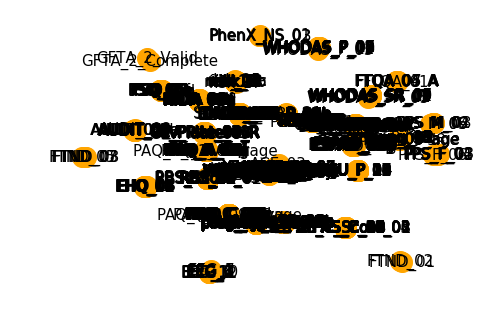

In [22]:
# Transform it in a links data frame (3 columns only):
links = Pearson_ρ.stack().reset_index()
links.columns = ['q1', 'q2','corr']
 
# Remove self correlation (cor(A,A)=1)
links_filtered=links.loc[ (links['q1'] != links['q2']) ]
links_filtered=links_filtered.assign(
    corr=links_filtered["corr"].apply(
        lambda x: 1/abs(x) if x != 0 else np.inf
    )
)
 
# Build your graph
G=nx.from_pandas_dataframe(links_filtered, 'q1', 'q2')
 
# Plot the network:
nx.draw(G, with_labels=True, node_color='orange', node_size=400, edge_color='black', linewidths=1, font_size=15)

Export for Cytoscape

In [12]:
nx.write_graphml(G, "Pearson_ρ.graphml")

In [23]:
graphs = list(nx.connected_component_subgraphs(G))


[<networkx.classes.graph.Graph object at 0x7f5e94c17a58>, <networkx.classes.graph.Graph object at 0x7f5e94c17208>, <networkx.classes.graph.Graph object at 0x7f5e94c17e80>, <networkx.classes.graph.Graph object at 0x7f5e94c17d30>, <networkx.classes.graph.Graph object at 0x7f5e94c17ba8>, <networkx.classes.graph.Graph object at 0x7f5e94c17198>, <networkx.classes.graph.Graph object at 0x7f5e94c17dd8>, <networkx.classes.graph.Graph object at 0x7f5e94c17128>, <networkx.classes.graph.Graph object at 0x7f5e94c17ac8>, <networkx.classes.graph.Graph object at 0x7f5e94c17d68>, <networkx.classes.graph.Graph object at 0x7f5e94c17940>, <networkx.classes.graph.Graph object at 0x7f5ead5815f8>, <networkx.classes.graph.Graph object at 0x7f5ead5812e8>, <networkx.classes.graph.Graph object at 0x7f5ead581828>, <networkx.classes.graph.Graph object at 0x7f5ead581630>, <networkx.classes.graph.Graph object at 0x7f5ead581438>, <networkx.classes.graph.Graph object at 0x7f5ead5817b8>, <networkx.classes.graph.Graph 

In [24]:
def jgraph_from_links_filtered(df):
    """
    Function to create a jgraph-readable dict from
    networkx-readable DataFrame
    
    Parameter
    ---------
    df: DataFrame
        three columns: source, destination, magnitude
        
    Returns
    -------
    jdict: dictionary
        dictionary of nodes and edges
    """
    edges = []
    for edge in df.iterrows():
        edges.append(
            {
                "source": edge[1][
                    df.columns[0]
                ],
                "target": edge[1][
                    df.columns[1]
                ],
                "size": edge[1][
                    df.columns[2]
                ]
            }
        )
    jdict = {
        "nodes": {
            **{
                node: {} for node in list(
                    df[
                        df.columns[0]
                    ]
                )
            }, **{
                node: {} for node in list(
                    df[
                        df.columns[1]
                    ]
                )
            }
        },
        "edges": edges
    }
    return(jdict)

In [28]:
for subg in graphs:
    jgraph.draw(subg)

In [ ]:
jgraph.draw(J)

In [10]:
J

{'edges': [{'size': 1.4609502069708564,
   'source': 'ACE_01',
   'target': 'ACE_02'},
  {'size': 10.412904082366817, 'source': 'ACE_01', 'target': 'ACE_03'},
  {'size': 8.526214471538177, 'source': 'ACE_01', 'target': 'ACE_04'},
  {'size': 2.1355575526325845, 'source': 'ACE_01', 'target': 'ACE_05'},
  {'size': 12.421786556288925, 'source': 'ACE_01', 'target': 'ACE_06'},
  {'size': 2.135557552632583, 'source': 'ACE_01', 'target': 'ACE_07'},
  {'size': 3.996294580029157, 'source': 'ACE_01', 'target': 'ACE_08'},
  {'size': 2.836831354749195, 'source': 'ACE_01', 'target': 'ACE_09'},
  {'size': 5.8797473220733325, 'source': 'ACE_01', 'target': 'ACE_10'},
  {'size': 4.183300132670377, 'source': 'ACE_01', 'target': 'ARI_P_01'},
  {'size': 4.183300132670377, 'source': 'ACE_01', 'target': 'ARI_P_02'},
  {'size': 3.162277660168379, 'source': 'ACE_01', 'target': 'ARI_P_03'},
  {'size': 7.416198487095666, 'source': 'ACE_01', 'target': 'ARI_P_04'},
  {'size': 5.0, 'source': 'ACE_01', 'target': 'AR